In [1]:
import requests
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation

In [2]:
class TspParser:
    name: str
    dimension: int
    nodeCoordinates: dict
    coordinatesTensor: list

    def __init__(self, fileContent):
        self.nodeCoordinates = {}
        unprocessedData = fileContent.split("\n")
        isCoordinateSection = False
        for line in unprocessedData:
            line = line.strip()

            if "EOF" in line:
                break
            if "NAME" in line:
                nameData = line.split(":")
                self.name = nameData[1] if len(nameData) == 2 else None
            if "DIMENSION" in line:
                dimensionData = line.split(":")
                self.dimension = int(dimensionData[1]) if len(dimensionData) == 2 else None
                
            if isCoordinateSection:
                line = line.strip()
                stringData = line.split()
                nodeId = int(stringData[0])
                x = float(stringData[1])
                y = float(stringData[2])
                self.nodeCoordinates[nodeId] = (x, y)
                
            if "NODE_COORD_SECTION" in line:
                isCoordinateSection = True

        self.coordinatesTensor = torch.tensor(list(self.nodeCoordinates.values()), dtype=torch.float32)


In [3]:
def compute_distance_matrix(coordinatesTensor):
    nodeCount = coordinatesTensor.shape[0]
    distance_matrix = torch.zeros((nodeCount + 1, nodeCount + 1))
    for i in range(1, nodeCount + 1):
        for j in range(1, nodeCount + 1):
            if i != j:
                distance_matrix[i, j] = torch.norm(coordinatesTensor[i-1] - coordinatesTensor[j-1])

    return distance_matrix

In [15]:
#works: berlin52, burma14
#nearly works: lin105 after 1000 iterations
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/lin105.tsp")
ulysses22 = TspParser(response.text)
distance_matrix = compute_distance_matrix(ulysses22.coordinatesTensor)

In [5]:
def plotBestPath(nodeCoordinates, distance_matrix, best_path, plotAllEdges=False):
    xCoords = [coord[0] for coord in nodeCoordinates.values()]
    yCoords = [coord[1] for coord in nodeCoordinates.values()]
    plt.figure(figsize=(20, 20))
    plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
    nodeCount = len(nodeCoordinates)
    if plotAllEdges:
        for i in range(1, nodeCount + 1):
            for j in range(i + 1, nodeCount + 1): 
                if distance_matrix[i, j] > 0:
                    x1, y1 = nodeCoordinates[i ]
                    x2, y2 = nodeCoordinates[j]
                    plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.3)
                
    xValues = []
    yValues = []
    bestPath = best_path.tolist()

    for i in bestPath:
        coords = nodeCoordinates[i]
        xValues.append(coords[0])
        yValues.append(coords[1])

    for i in range(len(xValues) - 1):
        plt.plot(xValues[i:i+2], yValues[i:i+2], 'ro-', markersize=5, label='Best Path' if i == 0 else "")
    plt.plot([xValues[-1], xValues[0]], [yValues[-1], yValues[0]], 'ro-', markersize=5)
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.title('Node Coordinates')
    plt.legend()
    plt.show()


In [6]:
class Particle:
   
    def __init__(self, nodeCount, swapCount=3, greedy=True):
        self.swapCount = swapCount
        self.nodeCount = nodeCount
        if greedy:
            self.initializeRouteKNN(distance_matrix=distance_matrix)
        else:
            self.position = torch.randperm(nodeCount) + 1
        self.fitnessValue = float("inf")
        self.localBestFitnessPosition = self.position.clone() 
        self.localBestFitnessValue = float("inf")
      
        #self.velocity = [torch.randint(0, nodeCount, (2,)) for _ in range(swapCount)]
        #print(self.velocity)
        #self.localBestVelocity = self.velocity
        self.bestCost = float("inf")
        
    #calculate length of current route. Goes through every element in position, and uses distance matrix to get edge length
    def calculateLength(self, distance_matrix):
        tour = self.position.tolist() 
        total_distance = sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        total_distance += distance_matrix[tour[-1], tour[0]]
        self.fitnessValue = total_distance
        return total_distance
    
    def calculateRouteLength(self, position, distanceMatrix):
        tour = position.tolist() 
        total_distance = sum(distanceMatrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        total_distance += distanceMatrix[tour[-1], tour[0]]
        return total_distance
    
    def initializeRouteKNN(self, distance_matrix, k=5):
        nodeCount = distance_matrix.shape[0] - 1  # Adjust for zero-indexing
        startNode = torch.randint(1, nodeCount + 1, (1,)).item()  # Start from a random node (1-indexed)
        route = [startNode]  # Start with the chosen node
        unvisited = set(range(1, nodeCount + 1)) - {startNode}  # Remaining nodes

        currentNode = startNode
        while unvisited:
            distances = distance_matrix[currentNode, 1:]  
            nearestNeighbors = sorted([(distances[i], i + 1) for i in range(nodeCount) if (i + 1) in unvisited])[:k]
            nextNode = nearestNeighbors[torch.randint(0, len(nearestNeighbors), (1,)).item()][1]    
            route.append(nextNode)
            unvisited.remove(nextNode)
            currentNode = nextNode

        self.position = torch.tensor(route) 

    def swapMutation(self, globalBestPath):  
        # segment_length = torch.randint(1, self.nodeCount // 4, (1,)).item()  
        # start_idx = torch.randint(0, self.nodeCount - segment_length, (1,)).item()
        # segment = globalBestPath[start_idx:start_idx + segment_length]
    
        # newPosition = self.position.tolist()  
        # newPosition = [node for node in newPosition if node not in segment] 
        # insert_idx = torch.randint(0, len(newPosition) + 1, (1,)).item()
        # newPosition[insert_idx:insert_idx] = segment 
        # newPosition = torch.tensor(newPosition, dtype=torch.long)

        # if self.calculateRouteLength(newPosition, distance_matrix) < self.calculateRouteLength(self.position, distance_matrix):
        #     self.position = newPosition.clone()

        newPosition = self.position.tolist() 
        innerCount = 0
        foundBetter = False
        def extract_and_insert_segment(source_path):
            segment_length = torch.randint(1, self.nodeCount // 4, (1,)).item()  # Random segment length
            start_idx = torch.randint(0, self.nodeCount - segment_length, (1,)).item()
            segment = source_path[start_idx:start_idx + segment_length]
            # Remove the segment from the current position
            temp_position = [node for node in newPosition if node not in segment]
            # Choose a random reinsertion point
            insert_idx = torch.randint(0, len(temp_position) + 1, (1,)).item()
            temp_position[insert_idx:insert_idx] = segment  # Insert segment
            return temp_position
        
        while foundBetter != True and innerCount < 10:
            candidates = [
                extract_and_insert_segment(globalBestPath),
                extract_and_insert_segment(self.localBestFitnessPosition),
                extract_and_insert_segment(self.position)  # Random segment from current position
            ]

            # Convert to tensors and choose the best candidate
            best_candidate = min(
                (torch.tensor(c, dtype=torch.long) for c in candidates),
                key=lambda pos: self.calculateRouteLength(pos, distance_matrix)
            )

            # Accept the new position if it's an improvement
            if self.calculateRouteLength(best_candidate, distance_matrix) < self.calculateRouteLength(self.position, distance_matrix):
                self.position = best_candidate.clone()
                foundBetter = True
            innerCount += 1

In [7]:
class ParticleSwarmOptimiser:
    def __init__(self, nodeCount, particleCount, inertia, particleCognition, socialInfluence, r1=1, r2=1, alpha=1, beta=1):
        self.particleSwarm = [Particle(nodeCount, swapCount=3) for _ in range(particleCount)]
        self.w = inertia
        self.c1 = particleCognition
        self.c2 = socialInfluence
        self.r1 = r1
        self.r2 = r2
        self.beta = beta
        self.alpha = alpha
        self.globalBestFitnessPosition = self.particleSwarm[0].position.clone()
        self.globalBestFitnessValue = float("inf")
        self.particleCount = particleCount
        #self.globalBestVelocity = self.particleSwarm[0].velocity
    
    def getBestSolution(self):
        return self.globalBestFitnessPosition, self.globalBestFitnessValue

    def optimise(self, distance_matrix, maxIterations):
        for iteration in range(maxIterations):
            #print(self.globalBestVelocity)
            print(iteration)
            for particle in self.particleSwarm:
                fitness = particle.calculateLength(distance_matrix)
                #print(f"particles best path: {particle.localBestFitnessPosition}")
                #print(f"particles best value: {particle.localBestFitnessValue}")
                if fitness < particle.localBestFitnessValue:
                    particle.localBestFitnessValue = fitness
                    particle.localBestFitnessPosition = particle.position.clone()
                    #particle.localBestVelocity = particle.velocity

                if fitness < self.globalBestFitnessValue:
                    self.globalBestFitnessValue = fitness
                    self.globalBestFitnessPosition = particle.position.clone()
                    #self.globalBestVelocity = particle.localBestVelocity

            for particle in self.particleSwarm:
                particle.swapMutation(self.globalBestFitnessPosition)
                #particle.updateVelocity(self.globalBestVelocity, distance_matrix)
            print(f"particles best path: {self.globalBestFitnessPosition}")
            print(f"particles best value: {self.globalBestFitnessValue}")
            # if self.globalBestFitnessValue < 40000:
            #     break
                        
    def refine():
        #take in new hyperparameters without necessarily modifying particle swarm
        pass


0
particles best path: tensor([ 66,  87,  94,  88,  70,  75,  80,  76,  74,  81,  73,  77,  68,  67,
         79,  86,  83,  82,  72,  71,  85,  91,  97,  92,  84,  69,  89,  93,
         90,  99,  95,  61,  58,  54,  51,  44,  47,  41,  53,  57, 105,  59,
         56,  55,  45,  50, 104,  49,  40,  31,  22, 103,  23,  29,  15,  20,
         28,  27,  19,  16,  25,  24,  26,  18,   8,   3,   6,   1,  11,  10,
         21,  30,  32,  36,  37,  33,  17,   9,  13,   4,  35,  42,  52,  46,
         48,  62,  64,  63,  60,  65,  39,  43,  38,  12,   7,   2,  14,  34,
          5,  96, 101, 102, 100,  98,  78])
particles best value: 35688.0078125
1
particles best path: tensor([ 66,  87,  94,  88,  70,  75,  80,  76,  74,  81,  73,  77,  68,  67,
         79,  86,  83,  82,  72,  71,  85,  91,  97,  92,  84,  69,  89,  93,
         90,  99,  95,  61,  58,  54,  51,  44,  47,  41,  53,  57, 105,  59,
         56,  55,  45,  50, 104,  49,  40,  31,  22, 103,  23,  29,  15,  20,
         28,  27

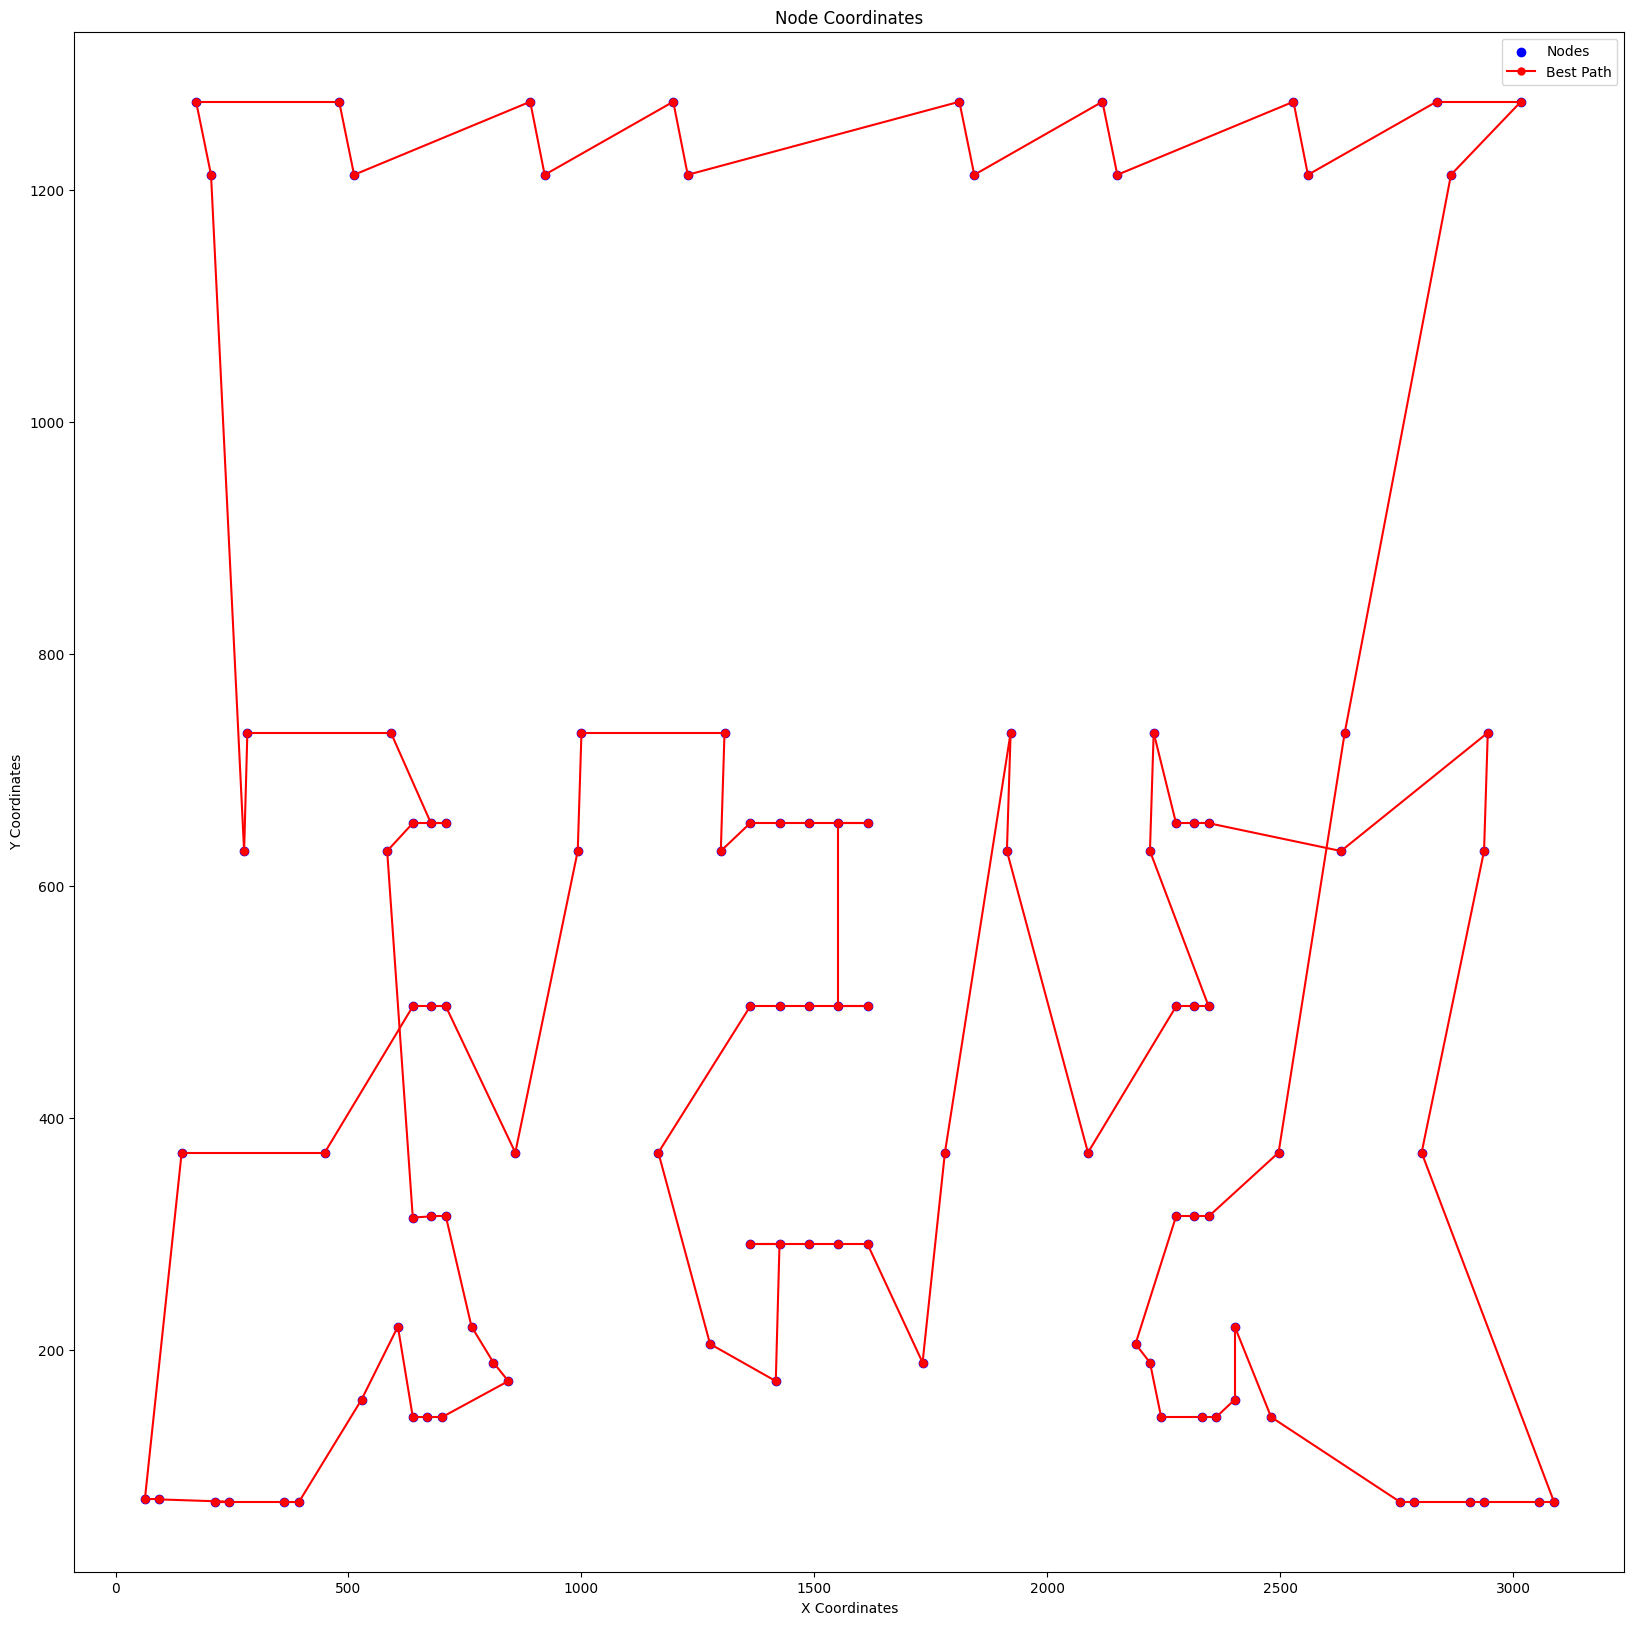

In [17]:

particleCount = 50
maxIterations = 1000
inertia = 0.8
c1 = 1.5
c2 = 1.5
pso = ParticleSwarmOptimiser(
    nodeCount=ulysses22.dimension,
    particleCount=particleCount,
    inertia=inertia,
    particleCognition=c1,
    socialInfluence=c2
)

pso.optimise(distance_matrix, maxIterations)
best_path, best_cost = pso.getBestSolution()

print("\nBest Path Found:", best_path.tolist())
print("Best Cost:", best_cost)
plotBestPath(ulysses22.nodeCoordinates, distance_matrix, best_path)